In [4]:
%pip install -q matplotlib networkx pandas torchinfo
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import functions
import matplotlib.pyplot as plt
import torch

In [8]:
dataset = functions.load_dataset({"data": {
        "window_size": 24,
        "stride_length": 1,
        "lead_time": 1,
        "normalized": True
}}, "test")

Loading dataset into memory...


100%|██████████| 375/375 [00:28<00:00, 13.36it/s]


In [11]:
edge_weight_histories = []
best_epochs = []

for path in ["runs/resgcn_adj_type_downstream/2023-04-22_21-30-45.run",
             "runs/resgcn_adj_type_upstream/2023-04-22_21-33-46.run",
             "runs/resgcn_adj_type_bidirectional/2023-04-22_21-38-12.run"]:
    chkpt = torch.load(path)
    edge_weight_histories.append([history["edge_weights"].nan_to_num() for history in chkpt["history"]["model_params"]])
    best_epochs.append(torch.tensor(chkpt["history"]["val_loss"]).argmin())

In [13]:
for i, s in enumerate(["downstream", "upstream", "bidirectional"]):
    print(s, "correlation matrix:")
    print(torch.corrcoef(torch.stack([edge_weight_histories[i][best_epochs[i]]] + [functions.get_edge_weights(adjacency_type, dataset.edge_attr)
             for adjacency_type in ["stream_length", "elevation_difference", "average_slope"]])))

downstream correlation matrix:
tensor([[ 1.0000,  0.0478,  0.1526,  0.0934],
        [ 0.0478,  1.0000,  0.3331, -0.1741],
        [ 0.1526,  0.3331,  1.0000,  0.5844],
        [ 0.0934, -0.1741,  0.5844,  1.0000]])
upstream correlation matrix:
tensor([[ 1.0000,  0.1399, -0.2113, -0.2461],
        [ 0.1399,  1.0000,  0.3331, -0.1741],
        [-0.2113,  0.3331,  1.0000,  0.5844],
        [-0.2461, -0.1741,  0.5844,  1.0000]])
bidirectional correlation matrix:
tensor([[ 1.0000,  0.0343, -0.1419, -0.1462],
        [ 0.0343,  1.0000,  0.3331, -0.1741],
        [-0.1419,  0.3331,  1.0000,  0.5844],
        [-0.1462, -0.1741,  0.5844,  1.0000]])


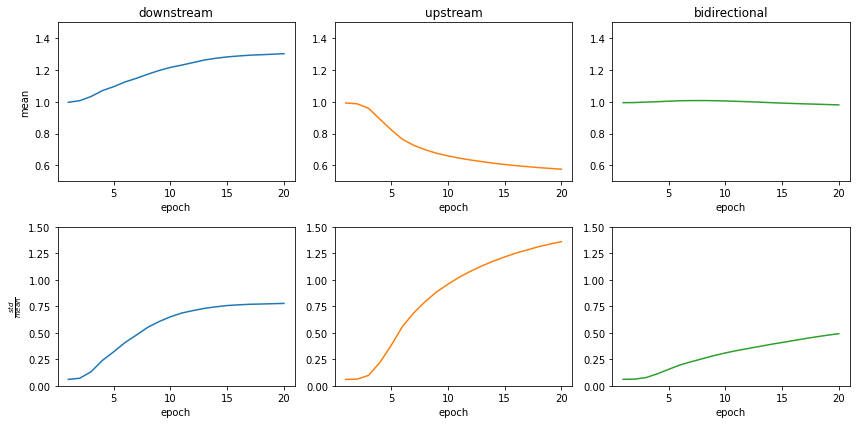

In [14]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, 1 + i)
    j = i % 3
    if i < 3:
        plt.title(["downstream", "upstream", "bidirectional"][j])
    x = [w.mean() if i < 3 else (w.std() / w.mean()) for w in edge_weight_histories[j]]
    plt.plot(range(1, len(edge_weight_histories[j]) + 1), x, color=plt.rcParams["axes.prop_cycle"].by_key()["color"][j])
    plt.xlabel("epoch")
    plt.ylim((0.5,1.5) if i < 3 else (0,1.5))
    plt.ylabel("mean" if i == 0 else "$\\frac{std}{mean}$" if i == 3 else "")
plt.tight_layout()
plt.savefig("learned_weights.pdf")
plt.show()